#I. Machine Prep

In [7]:
%pip install pandas
!apt install graphviz libgraphviz-dev
%pip install pygraphviz
%pip install powerlaw
%pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score, auc
import pprint
import numpy as np
from collections import OrderedDict
import powerlaw
import itertools as it
from typing import Dict, Set, Tuple
from scipy.optimize import minimize
import copy
from pprint import pprint

#II. Pedigree Graph Conversion

In [9]:
def pedfile_readin(pedfile):
    cols = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
    df = pd.read_csv(pedfile, sep=r'\s+', header=None, names=cols)
    return df


def construct_pedigree_graph(df, rm_floaters= True):
    G = nx.DiGraph()

    all_parents_set = set()
    founder_set = set()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
            all_parents_set.add(paternal_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)
            all_parents_set.add(maternal_id)
        if maternal_id == 0 and paternal_id == 0:
            founder_set.add(individual_id)

    #Removing founders with no children (i.e. floaters)
    if rm_floaters:
        floaters_set = founder_set - all_parents_set
        G.remove_nodes_from(floaters_set)


    return G

###Pedigree Graph Visualization

In [10]:
def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

#III. Pedigree Graph Analysis

###Simple Pedigree Helper Functions

In [11]:
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        #this check doesnt take into account children produced from one founder and one relative
        #leads all individuals to have the generation count to be minimum distance from most recent founder
        #if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl

def aff(G):
    return [n for n in G.nodes if G.nodes[n]['phenotype']==2]
def unaff(G):
    return [n for n in G.nodes if G.nodes[n]['phenotype']==1]


###Pedigree Feature Extraction and Metric Calculation

In [12]:
#################### MODULAR PEDIGREE FEATURES ####################
'''
Features: measures based on inheritence patterns gleaned from pedigree data alone,
no use of genotype or graph-specific data

Current List of Features:
-------------------------
1. Ratio Affected Parents
2. Generation Coverage
3. Affected Sibling Clustering
4. Average Betweeness of Unaffected
5. Average Betweeness of Carriers (CURRENTLY EXCLUDED)
6. Average Betweeness of Carriers in Affected+Carrier Subgraph (CURRENTLY EXCLUDED)
'''

# ---------------------------------------------------------------------
# 1. Ratio Affected Parents
# ---------------------------------------------------------------------
def ratio_aff_parents(G):
    aff_nodes = aff(G)
    aff_aff_partent = 0
    for n in aff_nodes:
        if any(G.nodes[p]['phenotype']==2 for p in parents(G,n)):
            aff_aff_partent +=1
    return aff_aff_partent/len(aff_nodes) if aff_nodes else 0


# ---------------------------------------------------------------------
# 2. Generation Coverage
# ---------------------------------------------------------------------
def gen_cov(G):
    gen = generations(G)
    gens_aff = {gen[n] for n in aff(G)}
    return len(gens_aff)/(max(gen.values())+1) if gen else 0


# ---------------------------------------------------------------------
# 3. Affected Sibling Clustering
# ---------------------------------------------------------------------
def sibling_aff_ratio(G):
    sib_pairs=0; aa_pairs=0
    for n in aff(G):
        for sib in siblings(G,n):
            if sib in aff(G):
                aa_pairs+=1
            sib_pairs+=1
    return aa_pairs/sib_pairs if sib_pairs else 0


# ---------------------------------------------------------------------
# 4. Average Betweeness of Unaffected
# ---------------------------------------------------------------------
def avg_bet_unaff(G):
    unaffecteds = unaff(G)
    bet = nx.betweenness_centrality(G)
    return np.mean([bet[n] for n in unaffecteds]) if unaffecteds else 0


# ---------------------------------------------------------------------
# 5. Average Betweeness of Carriers
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
# def avg_bet_carrier(G):
#     carriers = [n for n in unaff(G) if G.nodes[n]['phenotype'] == 1]
#     bet = nx.betweenness_centrality(G)
#     return np.mean([bet[n] for n in carriers]) if carriers else 0


# ---------------------------------------------------------------------
# 6. Average Betweeness of Carriers in Affected+Carrier Subgraph
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
# def avg_bet_carrier_subgraph(G):
#     aff_nodes = aff(G)
#     unaff_nodes = unaff(G)
#     carrier_nodes = [n for n in unaff_nodes if G.nodes[n]['genotype'] == 1]
#     bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier_nodes))
#     return np.mean([bet[n] for n in carrier_nodes]) if carrier_nodes else 0


# ---------------------------------------------------------------------
# PEDIGREE FEATURES WRAPPER
# ---------------------------------------------------------------------
def pedigree_features(G):
    return {
        'ratio_aff_parent': ratio_aff_parents(G),
        'gen_cov': gen_cov(G),
        'sibling_aff_ratio': sibling_aff_ratio(G),
        'avg_bet_unaff': avg_bet_unaff(G),

        # See exclusion reasoning in function description above
        #'avg_bet_carrier': avg_bet_carrier(G),
        #'avg_bet_carrier_subgraph': avg_bet_carrier_subgraph(G)
    }



In [13]:
#################### MODULAR GRAPH METRICS ####################
'''
Metrics: measures based on network structure and phenotype data independent of genotype data

Current List of Metrics:
-------------------------
1. Number of Nodes
2. Number of Edges
3. Number of Connected Components
4. Average Clustering Coefficient
5. Diameter
6. Average Shortest Path Length
7. Average Degree Centrality
8. Average Betweenness Centrality
9. Average Closeness Centrality
10. Power Law Alpha  (CURRENTLY EXCLUDED)
11. Power Law Xmin  (CURRENTLY EXCLUDED)
12. Sigma Small World (CURRENTLY EXCLUDED)
13. Pedigree Width
14. Number of Edges of Transitive Reduction
15. Transitive Reduction Size Ratio
16. Longest Path Length
17. Minimal Founder Coverage Size
18. Founder Influence
'''

# ---------------------------------------------------------------------
# 1. Basic Graph Metrics
# ---------------------------------------------------------------------
def basic_graph_metrics(G):
    G_u = G.to_undirected()
    return {
        'n_nodes': G.number_of_nodes(),
        'n_edges': G.number_of_edges(),
        'n_components': nx.number_connected_components(G_u),
        'avg_clustering': nx.average_clustering(G_u),
        'diameter': nx.diameter(G_u),
        'avg_path_len': nx.average_shortest_path_length(G_u)
    }

# ---------------------------------------------------------------------
# 2. Centralities
# ---------------------------------------------------------------------
def centralities(G):
    G_u = G.to_undirected()
    deg_cent = list(nx.degree_centrality(G_u).values())
    bet_cent = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())

    return {'avg_degree_centrality': float(np.mean(deg_cent)),
            'avg_betweenness': float(np.mean(bet_cent)),
            'avg_closeness': float(np.mean(clos_cent))
    }

# ---------------------------------------------------------------------
# 3. Small-world Sigma
# ---------------------------------------------------------------------
'''
Currently unused given extreme computational bottleneck
'''
# def sigma_small_world(G):
#     # opted for plug-and-play sigma calculation from NetworkX over first principals calculation
#     # niter and nrand parameter values lowered to decrease computation time
#     return nx.sigma(G, niter= 1, nrand= 1)


# ---------------------------------------------------------------------
# 4. Power-law Exponent
# ---------------------------------------------------------------------
# '''
# Previously made use of full graph (floaters included),
# floater culling may have changed functionaly slightly
# '''
# def power_law_exponent(G):
#     degrees = [d for _, d in G.degree()]
#     fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
#     return {
#         'pl_alpha': round(fit.power_law.alpha, 3),
#         'pl_xmin': fit.power_law.xmin
#         }

# ---------------------------------------------------------------------
# 5. Pedigree Width
# ---------------------------------------------------------------------
def pedigree_width(G: nx.DiGraph) -> int:
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG.")
    #transitive closure creates new graph including all origianl edges and adding edges between all nodes connected by a path
    #i.e. for AD pedigree adds 4 edges connecting both grandparents to both of their grandchildren
    P = nx.algorithms.dag.transitive_closure(G)
    left  = {f"{n}_L" for n in G}
    right = {f"{n}_R" for n in G}
    B = nx.DiGraph()
    B.add_nodes_from(left,  bipartite=0)
    B.add_nodes_from(right, bipartite=1)
    for u, v in P.edges:
        B.add_edge(f"{u}_L", f"{v}_R")
    match = nx.algorithms.bipartite.maximum_matching(B, top_nodes=left)
    matched = len(match) // 2
    width = G.number_of_nodes() - matched
    return width

# ---------------------------------------------------------------------
# 6. Transitive Reduction Size
# ---------------------------------------------------------------------
# How does transitive reduction work with our pedigrees?
# nx.transitive_reduction only returns a list of duples for edges in transitive reduction
# would only cull child-parent relationships in cases of consanguinity between partent and other child
def dict_transitive_reduction_size(G):
    red = nx.transitive_reduction(G)
    return {'TR_n_edges': red.number_of_edges(),
            'TR_edge_ratio': red.number_of_edges()/G.number_of_edges()}

# ---------------------------------------------------------------------
# 7. Longest Path Length
# ---------------------------------------------------------------------
def longest_path_length(G):
    return nx.dag_longest_path_length(G)

# ---------------------------------------------------------------------
# 8. Minimal Founder Coverage
# ---------------------------------------------------------------------
def minimal_founder_cover_set(G: nx.DiGraph) -> set:
    """
    Return one minimal founder cover (greedy) as a Python set.
    """
    #different founder condition than used in score enhancement (no stipulation on genotype)
    founders = [n for n in G if G.in_degree(n) == 0]
    cover, uncovered = set(), set(G.nodes)
    while uncovered:
        best = max(founders, key=lambda f: len(nx.descendants(G, f) & uncovered) + (f in uncovered))
        cover.add(best)
        uncovered -= nx.descendants(G, best)
        uncovered.discard(best)
    return cover

def minimal_founder_coverage_size(G: nx.DiGraph) -> float:
    """
    Return the size of the minimal founder coverage set.
    """
    return len(minimal_founder_cover_set(G))

# ---------------------------------------------------------------------
# 9. Founder Influence
# ---------------------------------------------------------------------
def founder_influence(G) -> Dict[str, float]:
    phen = nx.get_node_attributes(G, "phenotype")
    affected = {n for n, p in phen.items() if p == 2}
    memo_all, memo_aff = {}, {}
    def paths(u, memo, target=None):
        key = (u, id(target))
        if key in memo: return memo[key]
        total = 1 if target is None or u in target else 0
        for v in G.successors(u):
            total += paths(v, memo, target)
        memo[key] = total
        return total
    infl = {}
    for f in (n for n in G if G.in_degree(n)==0):
        all_p = paths(f, memo_all, None)
        aff_p = paths(f, memo_aff, affected)
        infl[f] = aff_p / all_p if all_p else 0
    return infl


# ---------------------------------------------------------------------
# GRAPH METRICS WRAPPER
# ---------------------------------------------------------------------
def graph_metrics(G):
    metrics = {**basic_graph_metrics(G), **centralities(G), **dict_transitive_reduction_size(G)}
    #metrics = {**metrics, **power_law_exponent(G)}
    #metrics['sigma_small_world'] = sigma_small_world(G)
    metrics['width'] = pedigree_width(G)
    metrics['longest_path'] = longest_path_length(G)
    metrics['founder_cover_size'] = minimal_founder_coverage_size(G)
    metrics['founder_influence'] = founder_influence(G)

    return metrics



Additional Graph Metrics
* accssible via summar wrapper function

In [14]:
#################### MODULAR VARIANT SCORING ####################
'''
Scores: measures of variant association likelihoods accounting for graph/pedigree structure as well as genotype and phenotype data,
provided in mode agnostic form

Current List of Scores:
-------------------------

'''
#----------------------------------------------------------------------
# 1v2. Edge Consistency
#----------------------------------------------------------------------
def edge_consistency(G, gt):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.

    Given working off of genotypes, mode is irrelevant.
    """
    #partental genotype (pg,mg) | (mg,pg) --> possible child genotypes {}
    ALLOWED_INHERITENCE = {
        (0,0):{0}, (1,0):{0,1}, (1,1):{0,1,2}, (2,1):{1,2}, (2,0):{1}, (2,2):{2}
    }
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        if len(prnts) < 2:
            continue
        gp,gm=[gt[p] for p in prnts]
        par_gt = (gp,gm) if (gp,gm) in ALLOWED_INHERITENCE.keys() else (gm,gp)
        if gt[child] in ALLOWED_INHERITENCE[par_gt]:
            good+=1
        total+=1
    return good/total

# ---------------------------------------------------------------------
# 2. Generation Continuity
# ---------------------------------------------------------------------
def generation_continuity(G, gt):
    """
    Return the fraction of generations with carriers (by genotype)
    """
    gen = generations(G)
    gens_total = max(gen.values())+1
    alt_gens = {gen[n] for n in G if gt[n]>0}
    return len(alt_gens)/gens_total if alt_gens else 0


# ---------------------------------------------------------------------
# 3v1. Carrier Betweeness
# ---------------------------------------------------------------------
'''
Currently defunct so as to trial subgraph version that prunes graph to affected nodes and carriers
'''
# def carrier_betweenness(G, gt):
#     phen = nx.get_node_attributes(G, "phenotype")
#     het_car=[n for n in G if gt[n]==1 and phen[n]!=2]

#     if het_car:
#         bet = nx.betweenness_centrality(G)
#         cb = sum(bet[n] for n in het_car)/len(het_car)
#         cb /= max(bet.values()) if bet else 1
#         return cb
#     else:
#         return 0
# ---------------------------------------------------------------------
# 3v2. Betweeness of Carriers in Affected+Carrier Subgraph
# ---------------------------------------------------------------------
'''
Currently defunct based on necessary inclusion of genotype data
which is not included in pedigree graph alone
'''
def carrier_betweenness(G, gt):
    aff_nodes = aff(G)
    unaff_nodes = unaff(G)
    carrier_nodes = [n for n in unaff_nodes if gt[n] == 1]
    carrier_aff_subgraph = G.subgraph(aff_nodes+carrier_nodes)
    subgraph_bet = nx.betweenness_centrality(carrier_aff_subgraph)
    total_bet = nx.betweenness_centrality(G)
    carrier_betweenness = np.mean([subgraph_bet[n] for n in carrier_aff_subgraph]) if carrier_nodes else 0
    carrier_betweenness /= max(total_bet.values()) if max(total_bet.values()) else 1
    return carrier_betweenness

# ---------------------------------------------------------------------
# VARIANT SCORING WRAPPER
# ---------------------------------------------------------------------
'''
Mode agnostics raw variant scores
'''
def variant_scores(G, gt):
    return {
        'edge_consistency': edge_consistency(G, gt),
        'generation_continuity': generation_continuity(G, gt),
        'carrier_betweenness': carrier_betweenness(G, gt)
    }

In [15]:
# ---------------------------------------------------------------------
# 1v1. Original Edge Consistency Scoring
# ---------------------------------------------------------------------
def old_edge_consistency(G, gt, mode="AD"):
    """
    Fraction of parent→child edges whose genotype transition is Mendelian-
    compatible under the specified inheritance mode.
    gt is a dict {node: 0/1/2}.
    """
    ALLOWED_INHERITENCE = {
        'AD': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
        'AR': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,_):{1,2}},
    }
    good=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        par_gt = (gp,gm) if (gp,gm) in ALLOWED_INHERITENCE[mode] else (gm,gp)
        par_gt = (2,_) if par_gt not in ALLOWED_INHERITENCE[mode] else par_gt
        if gt[child] in ALLOWED_INHERITENCE[mode][par_gt]:
            good+=1
        total+=1
    return good/total

#IV. Pedigree and Variant Table Simulation

In [16]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, alt_freq, AffectedSpouse= False, BackpropLikelihood= False):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

In [17]:
def simulate_variant_table(G, mode='AD', n_bg=5):
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G,'phenotype')
    vars = {}
    # causal
    causal = 'chr1:100000_A>T'
    gt = {s:0 for s in samples}
    if mode=='AD':
        for s in samples:
            if phen[s]==2:
                gt[s]=1
        any_aff = [n for n in samples if phen[n]==2][0]
        for p in G.predecessors(any_aff):
            gt[p]=1
    else:
        for s in samples:
            if phen[s]==2:
                gt[s]=2
                for p in G.predecessors(s):
                    gt[p]=1
    vars[causal]=gt
    # background
    for i in range(n_bg):
        vid=f'chr1:{100200+i}_G>C'
        vars[vid]={s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in samples}
    return vars




In [18]:
def pedigree_group_generator(pedigree_count, mode, max_children, generation_count, n_bg= 5, alt_freq = 0):
    Fam_Data_Dict = {}
    for Family_Num in range(1, pedigree_count+1):
        FamilyID = f'FAM{Family_Num}'

        #for cases in which alt_frequency is not given (defaults are mode-dependent)
        if not alt_freq:
          alt_freq = random.randint(2,8)/100 if mode == 'AD' else random.randint(5,20)/100

        QC_checks = 0
        QC_pass = False
        while not QC_pass:
            QC_checks += 1
            ped_df = pedigree_generator(max_children= max_children,
                                        FamilyID= FamilyID,
                                        mode= mode,
                                        generation_count= generation_count,
                                        alt_freq= alt_freq,
                                        BackpropLikelihood= random.choice([0.25,0.5,0.75]),
                                        AffectedSpouse= True)
            ped_dg = construct_pedigree_graph(ped_df)
            affected_nodes = aff(ped_dg)
            if len(affected_nodes) > 1 and len(ped_dg.nodes()) >= (generation_count * 2):
                QC_pass = True
            elif QC_checks >= 25:
                print(f'{mode} {FamilyID}: Failed QC checks, included despite QC failure to prioritize futher operations')
                QC_pass = True
        var_dict = simulate_variant_table(G= ped_dg,
                                          mode= mode,
                                          n_bg= n_bg)
        Fam_Data_Dict[FamilyID] = {'PedGraph': ped_dg, 'VarTable': var_dict}
    return Fam_Data_Dict

In [19]:
ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''
open('ad_complete.ped','w').write(ped_AD)


ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

DF_ad = pedfile_readin('ad_complete.ped')
DF_ar = pedfile_readin('ar_complete.ped')
G_ad = construct_pedigree_graph(DF_ad)
G_ar = construct_pedigree_graph(DF_ar)

In [20]:
vars_AD = simulate_variant_table(G_ad, 'AD')
vars_AR = simulate_variant_table(G_ar, 'AR')

In [21]:
AD_Fam_Data = pedigree_group_generator(pedigree_count= 100,
                                       mode= 'AD',
                                       max_children= 3,
                                       generation_count= 3,
                                       n_bg= 25)
AR_Fam_Data = pedigree_group_generator(pedigree_count= 100,
                                       mode= 'AR',
                                       max_children= 3,
                                       generation_count= 3,
                                       n_bg= 25)

AR FAM46: Failed QC checks, included despite QC failure to prioritize futher operations


#V. Mode of Inheritence Classification

###Size-dependent Threshold Determination

In [22]:
def trial_based_feature_threshold_determination(generation_count,
                                                trial_count=1000,
                                                max_children= 3,
                                                AD_alt_freq_range= (2,10),
                                                AR_alt_freq_range= (5,20),
                                                verbose = True,
                                                size_agnostic = False,
                                                accuracy_threshold = 0.7):
    '''
    Determines optimal inheritence pattern determination thresholds for pedigrees of given generation count
    based on a given number of randomly generated trial pedigrees
    '''

    def trial_pedigree_generation():
        nonlocal generation_count, trial_count, AD_alt_freq_range, AR_alt_freq_range, max_children, size_agnostic

        all_trial_pedigree_features = pd.DataFrame()

        for trialID in range(1, trial_count+1):
            famID = 'TestFam' + str(trialID)
            actual_mode = random.choice(['AD', 'AR'])
            alt_freq_min = AD_alt_freq_range[0] if actual_mode == 'AD' else AR_alt_freq_range[0]
            alt_freq_max = AD_alt_freq_range[1] if actual_mode == 'AD' else AR_alt_freq_range[1]
            alt_freq = random.randint(alt_freq_min, alt_freq_max)/100

            #Accounting for cases where we want thresholds that are not specific to a generation count
            if size_agnostic:
                #Run time seems to increase indefinitely if left to be size_agnostic so currently unusable feature
                trial_generation_count = random.randint(2, generation_count)
            else:
                trial_generation_count = generation_count

            QC_pass = False
            while not QC_pass:
                trial_pedigree_df = pedigree_generator(FamilyID= famID,
                                                       mode= actual_mode,
                                                       max_children= random.randint(2,max_children),
                                                       generation_count= trial_generation_count,
                                                       AffectedSpouse= True,
                                                       BackpropLikelihood= random.choice([0.25, 0.5, 0.75]),
                                                       alt_freq= alt_freq)
                trial_pedigree_dg = construct_pedigree_graph(trial_pedigree_df)

                affecteded_nodes = aff(trial_pedigree_dg)
                if len(affecteded_nodes) > 1 and len(trial_pedigree_dg.nodes()) > (generation_count * 2) - 1:
                    QC_pass = True


            trial_feat_met_dict = {**pedigree_features(trial_pedigree_dg), **graph_metrics(trial_pedigree_dg), **{'actual_mode': actual_mode}}
            trial_feat_met_df = pd.DataFrame(trial_feat_met_dict, index= [0])

            all_trial_pedigree_features = pd.concat(objs= [all_trial_pedigree_features, trial_feat_met_df], ignore_index=True)

        return all_trial_pedigree_features




    def ROC_param_calc(true_labels, predicted_labels):
        real_pos_count = 0
        real_neg_count = 0
        true_pos_count = 0
        false_pos_count = 0

        for i in range(len(true_labels)):
            if true_labels[i] == 'AD':
                real_pos_count += 1
                if predicted_labels[i] == 'AD':
                    true_pos_count += 1
            elif true_labels[i] == 'AR':
                real_neg_count += 1
                if predicted_labels[i] == 'AD':
                    false_pos_count += 1


        TPR = true_pos_count/real_pos_count
        FPR = false_pos_count/real_neg_count

        return TPR, FPR

    def AUC_calc(FPR_scores, TPR_scores):
        FPR_arr = np.array(FPR_scores)
        TPR_arr = np.array(TPR_scores)

        sort_indx = np.argsort(FPR_arr)
        FPR_arr = FPR_arr[sort_indx]
        TPR_arr = TPR_arr[sort_indx]

        auc_score = auc(FPR_arr, TPR_arr)

        return auc_score

    def ROC_plot(features, TPR_score_dict, FPR_score_dict):

        fig = plt.figure()
        ax = plt.subplot(111)

        for feature in features:
            AUC_score = AUC_calc(FPR_scores= FPR_score_dict[feature],
                                 TPR_scores= TPR_score_dict[feature])
            ax.plot(FPR_score_dict[feature], TPR_score_dict[feature],
                    label= f'{feature} = {AUC_score:.2f}')

        ax.plot([0,1], [0,1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Mode of Inheritance ROC')
        ax.grid(True)

        box= ax.get_position()
        ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                  ncol= 2, fancybox=True, shadow=True)


    def single_feature_threshold_determination(feature_values, actual_mode_labels):
        min_value = min(feature_values)
        max_value = max(feature_values)
        thresh_increment = (max_value - min_value)/100
        min_value = min_value - thresh_increment
        threshold_options = [min_value+(thresh_increment*i) for i in range(103)]

        best_threshold = None
        best_accuracy = 0
        best_direction = None

        #Test accuracy of each threshold (both as upper and lower limit of AD classification) and store accuracy score
        TPR_scores = []
        FPR_scores = []
        for threshold in threshold_options:
            greater_equal_predictions = ['AD' if value > threshold else 'AR' for value in feature_values]
            less_predictions = ['AD' if value <= threshold else 'AR' for value in feature_values]

            greater_equal_accuracy = accuracy_score(actual_mode_labels, greater_equal_predictions)
            less_accuracy = accuracy_score(actual_mode_labels, less_predictions)

            if greater_equal_accuracy > best_accuracy:
                best_accuracy = greater_equal_accuracy
                best_threshold = threshold
                best_direction = 'greater'
            elif less_accuracy > best_accuracy:
                best_accuracy = less_accuracy
                best_threshold = threshold
                best_direction = 'less_equal'

            TPR, FPR = ROC_param_calc(actual_mode_labels, greater_equal_predictions)
            TPR_scores.append(TPR)
            FPR_scores.append(FPR)

        return best_threshold, best_direction, best_accuracy, TPR_scores, FPR_scores

    accuracy_checks = 0
    max_accuracy_checks = 3
    accuracy_QC_pass = False
    while not accuracy_QC_pass and accuracy_checks < max_accuracy_checks:
        accuracy_checks += 1
        trial_features_df = trial_pedigree_generation()
        training_features_df = trial_features_df.sample(frac=0.8)
        testing_features_df = trial_features_df.drop(training_features_df.index)



        TPR_scores_dict = {}
        FPR_scores_dict = {}
        thresholds_dict = {}
        for feature in trial_features_df.columns.values:
            if feature == 'FamID' or feature == 'actual_mode':
                continue
            threshold, direction, accuracy, TPR_scores, FPR_scores = single_feature_threshold_determination(training_features_df[feature].values,
                                                                                                            training_features_df['actual_mode'].values)
            thresholds_dict[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
            TPR_scores_dict[feature] = TPR_scores
            FPR_scores_dict[feature] = FPR_scores

        mode_prediction_field = []
        for _,row in testing_features_df.iterrows():
            predicted_mode = inheritance_pattern_classification(row,
                                                                thresholds_dict = thresholds_dict)
            mode_prediction_field.append(predicted_mode)
        testing_features_df['predicted_mode'] = mode_prediction_field

        overall_classification_accuracy = accuracy_score(y_true= testing_features_df['actual_mode'],
                                                         y_pred= testing_features_df['predicted_mode'])

        certain_test_results_df = testing_features_df[testing_features_df['predicted_mode']!='Uncertain']
        num_certain_results = len(certain_test_results_df)
        certain_classification_accuracy = accuracy_score(y_true= certain_test_results_df['actual_mode'],
                                                         y_pred= certain_test_results_df['predicted_mode'])

        if certain_classification_accuracy >= accuracy_threshold and num_certain_results/len(testing_features_df) >= accuracy_threshold:
            accuracy_QC_pass = True



    if verbose:
        ROC_plot(features= thresholds_dict.keys(),
                 TPR_score_dict= TPR_scores_dict,
                 FPR_score_dict= FPR_scores_dict)
        print(f'Number of Certain Results: {num_certain_results}/{len(testing_features_df)}')
        print(f'Certain Classification Accuracy: {certain_classification_accuracy}')
        print(f'Overall Classification Accuracy: {overall_classification_accuracy}')

    return thresholds_dict

def inheritance_pattern_classification(sample_features,
                                       thresholds_dict,
                                       min_accuracy_score= 0.7) -> str:

    votes= 0
    total= 0
    for feature, descriptors in thresholds_dict.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        feature_value = sample_features[feature]

        if accuracy >= min_accuracy_score:
            total += 1
            if direction == 'greater':
                if feature_value > threshold:
                    votes += 1
            elif direction == 'less_equal':
                if feature_value <= threshold:
                    votes += 1

    if total == 0:
        return 'Uncertain'
    elif votes/total > 0.75:
        return 'AD'
    elif votes/total < 0.25:
        return 'AR'
    else:
        return 'Uncertain'


In [23]:
def classify_pedigree(G, thresholds_dict= 0) -> str:
    if isinstance(G, nx.DiGraph):
        if not thresholds_dict:
            thresholds_dict = trial_based_feature_threshold_determination(generation_count= max(generations(G).values())+1)
        pedigree_feats_mets = {**pedigree_features(G), **graph_metrics(G)}
    else:
        raise TypeError(f'Invalid Input Type: classify pedigree takes NetworkX directed graph with optional thresholds dict as input; given {type(G)}')

    return inheritance_pattern_classification(sample_features= pedigree_feats_mets,
                                              thresholds_dict= thresholds_dict)

In [24]:
def classify_multiple_pedigrees(Multi_Ped_Dict: dict, thresholds_dict= 0, same_size= True):
    if same_size:
        if not thresholds_dict:
            threshold_basis_graph = random.choice(list(Multi_Ped_Dict.values()))['PedGraph']
            thresholds_dict = trial_based_feature_threshold_determination(generation_count= max(generations(threshold_basis_graph).values())+1)
        for FamilyID in Multi_Ped_Dict.keys():
            G = Multi_Ped_Dict[FamilyID]['PedGraph']
            Multi_Ped_Dict[FamilyID]['pred_mode'] = classify_pedigree(G, thresholds_dict= thresholds_dict)
    return Multi_Ped_Dict

    # else:
    #     print('To be implemented later: classification of heterogeniously sized pedigrees')

In [25]:
def pedigree_group_mode_agreement(Multi_Ped_Dict: dict):
    '''
    Returns the mutliple pedigree data file with updated predicted modes as well as the
    most prevelant inheritance mode classification found in the predicted modes
    '''
    Multi_Ped_Dict = classify_multiple_pedigrees(Multi_Ped_Dict)
    mode_lst = [Multi_Ped_Dict[FamilyID]['pred_mode'] for FamilyID in Multi_Ped_Dict.keys()]
    agreed_mode = max(set(mode_lst), key= mode_lst.count)
    return Multi_Ped_Dict, agreed_mode

#VI. Segregation Scoring

In [26]:
def segregation_network_score(G, gt, mode, Scoring_Method= 'Original', weights={'w_edge':.6,'w_gen':0.2,'w_bet':0.2}):

    # edge score does not depend on mode??? gt inheritenc patter is the same regardless
    # shouldn't all variants follow mendelian pattern barring mutational event
    # made new edge consistency that looks at parental genotype and child phenotype pairings
    edge_score= edge_consistency(G,gt)

    # generation continuity
    gen_score= generation_continuity(G,gt)
    #Why are we reversing this for AR (wouldnt we also expect this to close to 1 for AR variants as well)???
    #this pattern seems to apply more to phenotype patterns not genotype
    # if mode=='AR':
    #     gen_score= 1-gen_score
    gen_score= max(0,min(1,gen_score)) #ensures genscore within [0,1]

    # carrier betweenness
    cb = carrier_betweenness(G, gt)
    cb = max(0,min(1,cb))
    bet_score= cb if mode=='AR' else 1-cb


    score = (weights['w_edge'] * edge_score) + (weights['w_gen'] * gen_score) + (weights['w_bet'] * bet_score)

    if Scoring_Method == 'Extended':

        #average founders influence
        founders = [n for n in G if G.in_degree(n)==0 and gt[n]>0]
        if founders:
            fi = founder_influence(G)
            found_score = sum(fi[f] for f in founders) / len(founders)
        else:
            found_score = 0

        #redundancy score
        red_score = edge_consistency(nx.transitive_reduction(G), gt)

        #depth score
        depth = longest_path_length(G)
        alt_nodes = [n for n in G if gt[n]>0]
        alt_depth = 0
        if depth and founders and alt_nodes:
            # shortest founder→alt path for each pair that is connected
            lengths = []
            for f in founders:
                for a in alt_nodes:
                    if nx.has_path(G, f, a):
                        lengths.append(nx.shortest_path_length(G, f, a))
            if lengths:
                alt_depth = max(lengths)
        depth_score = alt_depth / depth

        #width score
        width_score = pedigree_width(G) / 4

        #coverage score
        cover = minimal_founder_cover_set(G)
        cov_score = 0

        score += (weights['w_found'] * found_score) + (weights['w_red'] * red_score) + (weights['w_depth'] * depth_score) + (weights['w_width'] * width_score) + (weights['w_cov'] * cov_score)

    return score

def original_scan_variants(G, vars_dict, weights, mode='AD'):
    # mode= classify_pedigree(G)
    w_edge, w_gen, w_bet = weights
    scores={vid: segregation_network_score(G,gt,mode,w_edge, w_gen, w_bet) for vid,gt in vars_dict.items()}
    best=max(scores,key=scores.get)
    return best, scores


Scoring Helper Functions

In [27]:
def max_score_highligher(s):
    max = s == s.max()
    return ['background-color: green' if v else '' for v in max]

Weights Optimization

In [28]:
#Margin Objective Function
def margin_weight_optimization_objective(weights_lst, Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode):

    weights_dict = {weight_names[i]: weights_lst[i] for i in range(len(weight_names))}
    margins = []
    for FamilyID, FamilyData in Multi_Ped_Dict.items():
        G, VarTable = FamilyData['PedGraph'], FamilyData['VarTable']
        linked_score = segregation_network_score(G= G,
                                                 gt= VarTable[linked_variant],
                                                 mode= mode,
                                                 Scoring_Method= Scoring_Method,
                                                 weights= weights_dict)

        unlinked_scores = []
        for VarID, gt in VarTable.items():
            if VarID != linked_variant:
                unlinked_scores.append(segregation_network_score(G= G,
                                      gt= VarTable[VarID],
                                      mode= mode,
                                      Scoring_Method= Scoring_Method,
                                      weights= weights_dict))
        max_unlinked_score = max(unlinked_scores)

        margin = linked_score - max_unlinked_score
        margins.append(margin)

    avg_margin = np.mean(margins)

    return 1 - avg_margin


#Fraction Objective Function
def fraction_weight_optimization_objective(weights_lst, Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode):

    weights_dict = {weight_names[i]: weights_lst[i] for i in range(len(weight_names))}
    correct_margin = 0
    for FamilyID, FamilyData in Multi_Ped_Dict.items():
        G, VarTable = FamilyData['PedGraph'], FamilyData['VarTable']
        linked_score = segregation_network_score(G= G,
                                                 gt= VarTable[linked_variant],
                                                 mode= mode,
                                                 Scoring_Method= Scoring_Method,
                                                 weights= weights_dict)

        unlinked_scores = []
        for VarID, gt in VarTable.items():
            if VarID != linked_variant:
                unlinked_scores.append(segregation_network_score(G= G,
                                      gt= VarTable[VarID],
                                      mode= mode,
                                      Scoring_Method= Scoring_Method,
                                      weights= weights_dict))

        max_unlinked_score = max(unlinked_scores)

        if linked_score > max_unlinked_score:
            correct_margin += min((linked_score - max_unlinked_score), 1)

    fraction = correct_margin/len(Multi_Ped_Dict)

    return 1 - fraction


#Optimization Wrapper
def weights_optimization(Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, Optimization_Method, mode= 'AD'):
    n_weights = len(weight_names)
    bounds = [(0.001,1)]*n_weights
    constraints = {'type': 'eq',
                  #figure out how this function is working
                  'fun': lambda w: np.sum(w)-1}
    initial_guess = np.array([1/n_weights]*n_weights)

    if Optimization_Method == 'Margin':
        results = minimize(fun= margin_weight_optimization_objective,
                          x0= initial_guess,
                          args= (Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode),
                          bounds= bounds,
                          constraints= constraints)
    elif Optimization_Method == 'Fraction':
        results = minimize(fun= fraction_weight_optimization_objective,
                          x0= initial_guess,
                          args= (Multi_Ped_Dict, linked_variant, weight_names, Scoring_Method, mode),
                          bounds= bounds,
                          constraints= constraints)

    #Directly attaching weights with their names as dictionary for ease of use is scoring wrapper function
    optimized_weights = {weight_names[i]: results.x[i] for i in range(len(weight_names))}

    return optimized_weights

In [29]:
a = 0.3
b = 0.8
c = 1
c += min(a+b, 1)
print(c)

2


In [30]:
def segregation_scoring_wrapper(Multi_Ped_Dict: dict,
                                Scoring_Method= 'Original',
                                weights= 0,
                                Optimization_Method= 'None',
                                Verbose= True,
                                Known_Linked_Var= False,
                                Known_Mode= 0):
    '''
    Takes multi-pedigree data dictionaries as input and outputs the dictionary with updated scores
    '''
    if not Known_Mode:
        Multi_Ped_Dict, agreed_mode = pedigree_group_mode_agreement(Multi_Ped_Dict)
    else:
        agreed_mode = Known_Mode

    if Scoring_Method == 'Original':
        weight_names = ['w_edge', 'w_gen', 'w_bet']
    elif Scoring_Method == 'Extended':
        weight_names = ['w_edge', 'w_gen', 'w_bet', 'w_found', 'w_red', 'w_depth', 'w_width', 'w_cov']

    #manually assignment of weights if no weights given if using original scoring
    if not weights:
        if Optimization_Method == 'None':
            if Scoring_Method == 'Original':
                weights= {
                    'w_edge': 0.6,
                    'w_gen': 0.2,
                    'w_bet': 0.2
                }
            elif Scoring_Method == 'Extended':
                weights= {
                    'w_edge': 0.125,
                    'w_gen': 0.125,
                    'w_bet': 0.125,
                    'w_found': 0.125,
                    'w_red': 0.125,
                    'w_depth': 0.125,
                    'w_width': 0.125,
                    'w_cov': 0.125
                }
            print('Default Weights:')

        elif Optimization_Method == 'Margin' or Optimization_Method == 'Fraction':
            weights= weights_optimization(Multi_Ped_Dict= Multi_Ped_Dict,
                                                linked_variant= Known_Linked_Var,
                                                weight_names= weight_names,
                                                Scoring_Method= Scoring_Method,
                                                Optimization_Method= Optimization_Method,
                                                mode= agreed_mode)
            print(f'{Optimization_Method} Optimized Weights:')

        else:
            raise NotImplementedError

    else:
        print('Given Weights:')

    pprint(weights)


    All_Family_Score_df = pd.DataFrame(columns=Multi_Ped_Dict.keys())
    for FamilyID in Multi_Ped_Dict.keys():
        PedGraph, VarTable = Multi_Ped_Dict[FamilyID]['PedGraph'], Multi_Ped_Dict[FamilyID]['VarTable']
        if not Known_Mode:
            pred_mode = Multi_Ped_Dict[FamilyID]['pred_mode']
        else:
            pred_mode = Known_Mode

        #convert uncertain classified pedigrees to AD (can change scoring to accomodate later)
        #currently using agreed mode for scoring parameter so should not matter
        if pred_mode == 'Uncertain':
           pred_mode = 'AD'

        Multi_Ped_Dict[FamilyID][Scoring_Method] = {
                            VarID: segregation_network_score(G= PedGraph,
                                                              gt= VarTable[VarID],
                                                              mode= agreed_mode,
                                                              Scoring_Method= Scoring_Method,
                                                              weights= weights)
                            for VarID in VarTable.keys()}

        All_Family_Score_df[FamilyID] = Multi_Ped_Dict[FamilyID][Scoring_Method]

    #displaying scores if verbose option chosen
    if Verbose:
        #printing dataframe with highest scoring variant highlighted for each family
        print(f'{Scoring_Method} Segregation Scoring Results')
        styled_All_Family_Score_df = All_Family_Score_df.style.apply(max_score_highligher, axis=0)
        display(styled_All_Family_Score_df)

        if Known_Linked_Var:

            Correctly_Scored_Pedigrees = 0
            for FamilyID in Multi_Ped_Dict.keys():
                if max(Multi_Ped_Dict[FamilyID][Scoring_Method], key= Multi_Ped_Dict[FamilyID][Scoring_Method].get) == Known_Linked_Var:
                    Correctly_Scored_Pedigrees += 1
            Scoring_Method_Accuracy = Correctly_Scored_Pedigrees/len(Multi_Ped_Dict)
            print(f'{Scoring_Method} Segregation Scoring Accuracy: {Scoring_Method_Accuracy}')



    else:
        raise NotImplementedError



###Original Scoring with Default Weights

In [31]:
segregation_scoring_wrapper(Multi_Ped_Dict= AD_Fam_Data,
                            Scoring_Method= 'Original',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AD')

Default Weights:
{'w_bet': 0.2, 'w_edge': 0.6, 'w_gen': 0.2}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,0.933333,1.000000,1.000000,1.000000,0.933333,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.866667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,0.933333,1.000000,0.933333,0.933333,0.933333,1.000000,1.000000,1.000000,0.933333,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
chr1:100200_G>C,0.848611,0.695833,0.800000,0.583333,0.794444,0.800000,0.800000,0.673333,0.800000,0.661264,0.708571,0.899048,0.800000,0.866667,0.783333,0.695238,0.783333,0.700000,0.879365,0.903889,0.716667,0.858333,0.866667,0.814719,0.933333,0.760000,0.733333,0.866667,0.718333,0.933333,0.680000,0.843889,0.583333,0.733333,0.876364,0.912698,0.668803,0.866667,0.849524,0.768889,0.658392,0.573016,0.733333,0.896566,0.728333,0.820000,0.833333,0.426667,0.561905,0.951515,0.778095,0.709524,0.800000,0.579167,0.795238,0.673333,0.766190,0.766667,0.693333,0.666667,0.800000,0.570238,0.897143,0.753571,0.629167,0.800000,0.646667,0.748413,0.606638,0.661667,0.714286,0.666667,0.783333,0.800000,0.787057,0.773333,0.684444,0.616667,0.760606,0.779167,0.530238,1.000000,0.933333,0.596111,0.706667,0.741019,0.837870,0.777037,0.890909,0.796667,0.733333,0.809524,0.838095,0.853333,0.666667,0.716667,0.802857,0.655411,0.746667,0.748333
chr1:100201_G>C,0.697222,0.308333,0.746667,0.908333,0.746667,0.800000,0.746667,0.870476,0.693333,0.751412,0.825714,0.776190,0.800000,0.783333,0.783333,0.786508,0.625000,0.800000,0.596032,0.613333,0.554167,0.858333,0.791667,0.819481,0.783333,0.666667,0.856764,0.661905,0.728333,0.833333,0.828571,0.674444,0.764286,0.715000,0.774444,0.767619,0.837322,0.740000,0.718333,0.946667,0.789394,0.628175,0.658333,0.817643,0.658333,0.746667,0.633333,0.933333,0.780952,0.812121,0.806667,0.847619,0.800000,0.933333,0.657143,0.831429,0.710000,0.479167,0.813333,0.800000,0.866667,0.419048,0.633333,0.713333,0.866667,0.890000,0.751111,0.767619,0.804560,0.800000,0.766667,0.858333,0.643333,0.783333,0.857428,0.800000,0.684444,0.858333,0.659091,0.458333,0.705357,0.693333,0.813333,0.734444,0.899048,0.643056,0.766667,0.873333,0.551515,0.800000,0.583333,0.795238,0.783333,0.766667,0.800000,0.823016,0.616667,0.872727,0.813333,0.703434
chr1:100202_G>C,0.781944,0.716667,0.713333,0.716667,0.903232,0.699630,0.773333,0.712063,0.800000,0.811783,0.759048,0.631429,0.741667,0.633333,0.866667,0.681746,0.594444,0.866667,0.761905,0.757778,0.791667,0.858333,0.800000,0.569697,0.716667,0.613333,0.902448,0.747619,0.868333,0.935714,0.804286,0.801111,0.798214,0.733333,0.702222,0.773810,0.671950,0.806667,0.885714,0.813333,0.807273,0.847619,0.733333,0.890438,0.710000,0.953333,0.933333,0.626667,0.847619,0.779798,0.639524,0.775000,0.800000,0.800000,0.795238,0.806667,0.862143,0.445833,0.800000,0.800000,0.783333,0.800000,0.866667,0.834286,0.800000,0.561905,0.813333,0.646667,0.757576,0.860000,0.733333,0.86

Original Segregation Scoring Accuracy: 0.93


In [32]:
segregation_scoring_wrapper(Multi_Ped_Dict= AR_Fam_Data,
                            Scoring_Method= 'Original',
                            weights= {'w_edge': 1/3,
                                      'w_gen': 1/3,
                                      'w_bet': 1/3},
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode = 'AR')

Given Weights:
{'w_bet': 0.3333333333333333,
 'w_edge': 0.3333333333333333,
 'w_gen': 0.3333333333333333}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.909091,0.939394,0.494949,0.736111,0.305556,0.916667,0.916667,0.388889,0.722222,0.729630,0.888889,0.952381,0.333333,0.923077,0.944444,0.944444,0.355556,0.355556,0.925926,0.722222,0.355556,0.404040,0.472222,0.909091,0.388889,0.472222,0.525253,0.472222,0.916667,0.507937,0.365079,0.361111,0.703704,0.904762,0.727778,0.444444,0.828704,0.460317,0.504274,0.301587,0.891667,0.464646,0.948718,0.388889,0.317460,0.349206,0.939394,0.361111,0.916667,0.494949,0.744444,0.507937,0.909091,0.916667,0.404040,0.933333,0.430556,0.481481,0.930556,0.900000,0.513889,0.444444,0.930556,0.305556,0.925926,0.744444,0.952381,0.916667,0.925926,0.434343,0.930556,0.444444,0.933333,0.444444,0.861111,0.933333,0.925926,0.430556,0.388889,0.736111,0.407407,0.916667,0.407407,0.925926,0.779012,0.305556,0.888889,0.916667,0.857912,0.494949,0.962963,0.923077,0.909091,0.444444,0.434343,0.444444,0.944444,0.700000,0.736111,0.361111
chr1:100200_G>C,0.696008,0.555556,0.606061,0.333333,0.444444,0.748810,0.805556,0.333333,0.555556,0.685185,0.500000,0.571429,0.622222,0.555556,0.361111,0.630952,0.333333,0.616667,0.444444,0.444444,0.422222,0.874459,0.513889,0.924194,0.361111,0.777778,0.494949,0.441667,0.444444,0.444444,0.444444,0.823810,0.444444,0.634921,0.733333,0.444444,0.675926,0.793651,0.780220,0.412698,0.411111,0.555556,0.932051,0.455556,0.660714,0.460317,0.464646,0.811111,0.513889,0.919697,0.677778,0.333333,0.444444,0.944444,0.353535,0.377778,0.444444,0.444444,0.764683,0.488889,0.402778,0.711111,0.513889,0.638889,0.518519,0.700000,0.396825,0.900000,0.407407,0.746801,0.555556,0.833333,0.377778,0.388889,0.388889,0.933333,0.444444,0.402778,0.626984,0.388889,0.444444,0.388889,0.592593,0.444444,0.690895,0.333333,0.629630,0.472222,0.828283,0.464646,0.588889,0.796337,0.414141,0.444444,0.726107,0.518519,0.500000,0.361111,0.277778,0.796032
chr1:100201_G>C,0.484175,0.494949,0.731987,0.333333,0.638889,0.583333,0.513889,0.800000,0.305556,0.488889,0.444444,0.642857,0.444444,0.766178,0.638889,0.444444,0.748148,0.333333,0.444444,0.333333,0.551852,0.686869,0.444444,0.575758,0.333333,0.747222,0.777778,0.861111,0.780754,0.460317,0.333333,0.712302,0.333333,0.507937,0.596429,0.555556,0.513889,0.444444,0.589744,0.507937,0.666667,0.525253,0.721688,0.663492,0.444444,0.841270,0.494949,0.333333,0.583333,0.747727,0.755556,0.460317,0.383838,0.527778,0.636724,0.696296,0.730556,0.518519,0.361111,0.586111,0.655556,0.388889,0.402778,0.638889,0.555556,0.722222,0.724206,0.444444,0.333333,0.333333,0.513889,0.333333,0.650000,0.444444,0.388889,0.600000,0.444444,0.563889,0.388889,0.472222,0.518519,0.583333,0.699074,0.370370,0.444444,0.611111,0.962963,0.611111,0.696008,0.414141,0.518519,0.529915,0.590572,0.722222,0.383838,0.733333,0.500000,0.672222,0.333333,0.689683
chr1:100202_G>C,0.555556,0.464646,0.828283,0.444444,0.750000,0.444444,0.541667,0.833333,0.555556,0.377778,0.555556,0.972222,0.333333,0.615385,0.444444,0.611111,0.377778,0.566667,0.518519,0.333333,0.540741,0.702742,0.513889,0.525253,0.534722,0.444444,0.636364,0.625000,0.746825,0.613095,0.651455,0.962698,0.703704,0.333333,0.769444,0.333333,0.777778,0.841270,0.892348,0.333333,0.488889,0.798268,0.769658,0.411111,0.412698,0.507937,0.464646,0.730159,0.513889,0.606061,0.388889,0.460317,0.414141,0.638889,0.818561,0.388889,0.758333,0.555556,0.444444,0.522222,0.472222,0.805556,0.444444,0.444444,0.333333,0.722222,0.724206,0.444444,0.761111,0.555556,0.513889,0.38

Original Segregation Scoring Accuracy: 0.25


###Original Scoring with Optimized Weights

####Margin Optimization

In [33]:
segregation_scoring_wrapper(Multi_Ped_Dict= AD_Fam_Data,
                            Scoring_Method= 'Original',
                            Optimization_Method = 'Margin',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode = 'AD')

Margin Optimized Weights:
{'w_bet': np.float64(0.41630040715773536),
 'w_edge': np.float64(0.29214034594073796),
 'w_gen': np.float64(0.2915592469015266)}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,1.000000,1.000000,0.902814,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.902814,1.000000,0.902814,1.000000,1.000000,1.000000,0.902814,1.000000,0.902814,1.000000,1.000000,1.000000,1.000000,1.000000,0.902814,0.805627,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.902814,1.000000,1.000000,1.000000,0.902814,1.000000,1.000000,0.902814,1.000000,0.902814,0.902814,0.902814,1.000000,1.000000,1.000000,0.902814,0.902814,1.000000,1.000000,1.000000,1.000000,1.000000,0.805627,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.902814,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.805627,1.000000,1.000000,1.000000,1.000000,1.000000,0.902814,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
chr1:100200_G>C,0.768044,0.647647,0.708441,0.652668,0.655296,0.773167,0.708441,0.457299,0.708441,0.525275,0.584743,0.831448,0.708441,0.805627,0.829778,0.722158,0.829778,0.694470,0.885578,0.895621,0.493402,0.866296,0.805627,0.788293,0.902814,0.691792,0.805433,0.805627,0.694481,0.902814,0.743960,0.866407,0.413478,0.486513,0.838327,0.924588,0.540968,0.805627,0.728364,0.751874,0.767322,0.467753,0.486513,0.891008,0.595701,0.708490,0.854124,0.272471,0.403045,0.899079,0.675361,0.710314,0.773167,0.366655,0.752048,0.680543,0.752515,0.756937,0.636186,0.708247,0.708441,0.461971,0.785903,0.805979,0.550461,0.708441,0.688821,0.795241,0.657687,0.498514,0.724205,0.708247,0.829778,0.708441,0.703953,0.761125,0.617683,0.444712,0.714315,0.623496,0.464136,1.000000,0.902814,0.583589,0.632047,0.779850,0.853879,0.673159,0.946884,0.815951,0.486513,0.740204,0.746156,0.886065,0.708247,0.732592,0.749107,0.585253,0.555847,0.613412
chr1:100201_G>C,0.730268,0.319445,0.747199,0.850776,0.747199,0.773167,0.747199,0.730396,0.594605,0.776951,0.732900,0.735181,0.708441,0.632169,0.829778,0.733876,0.541788,0.708441,0.705860,0.428085,0.474078,0.866296,0.649515,0.798205,0.829778,0.389327,0.823165,0.611195,0.595701,0.854124,0.916531,0.596868,0.668820,0.554659,0.763438,0.664186,0.808579,0.554486,0.616466,0.888987,0.644784,0.445886,0.449996,0.768311,0.449996,0.747199,0.437823,0.902814,0.763893,0.779069,0.776413,0.861079,0.837894,0.902814,0.833063,0.808578,0.677135,0.317965,0.694614,0.708441,0.805627,0.652408,0.437823,0.657497,0.805627,0.771035,0.714870,0.664186,0.767148,0.708441,0.756937,0.746701,0.538368,0.632169,0.850430,0.708441,0.617683,0.746701,0.715624,0.392481,0.745486,0.722173,0.844386,0.584502,0.831448,0.552794,0.609992,0.873600,0.716906,0.708441,0.413478,0.752048,0.829778,0.747249,0.708441,0.714768,0.364982,0.822060,0.653033,0.765402
chr1:100202_G>C,0.865037,0.732592,0.786007,0.732592,0.894254,0.735279,0.611354,0.687688,0.708441,0.723403,0.635714,0.711198,0.743049,0.559134,0.805627,0.747594,0.478186,0.805627,0.819345,0.633070,0.649515,0.866296,0.708441,0.406839,0.732592,0.428085,0.876674,0.652929,0.767516,0.866189,0.729300,0.723269,0.739443,0.551240,0.613108,0.741798,0.653132,0.776413,0.881709,0.844386,0.758298,0.861079,0.486513,0.813526,0.755150,0.902863,0.902814,0.688771,0.861079,0.757186,0.524181,0.614823,0.773167,0.902620,0.752048,0.680737,0.832645,0.366462,0.708441,0.708441,0.632169,0.708441,0.805627,0.761372,0.708441,0.403045,0.844386,0.625037,0.752511,0.828185,0.805433,0.80

Original Segregation Scoring Accuracy: 0.88


In [34]:
segregation_scoring_wrapper(Multi_Ped_Dict= AR_Fam_Data,
                            Scoring_Method= 'Original',
                            Optimization_Method = 'Margin',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AR')

Margin Optimized Weights:
{'w_bet': np.float64(0.0010000000000000009),
 'w_edge': np.float64(0.0010000000000000009),
 'w_gen': np.float64(0.998)}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.999727,0.999818,0.666152,0.999208,0.665583,0.999750,0.999750,0.665833,0.999167,0.999189,0.999667,0.999857,0.665667,0.999769,0.999833,0.999833,0.665733,0.665733,0.999778,0.999167,0.665733,0.665879,0.666083,0.999727,0.665833,0.666083,0.666242,0.666083,0.999750,0.666190,0.665762,0.665750,0.999111,0.999714,0.999183,0.666000,0.999486,0.666048,0.666179,0.333238,0.999675,0.666061,0.999846,0.665833,0.665619,0.333381,0.999818,0.665750,0.999750,0.666152,0.999233,0.666190,0.999727,0.999750,0.665879,0.999800,0.665958,0.666111,0.999792,0.999700,0.666208,0.666000,0.999792,0.665583,0.999778,0.999233,0.999857,0.999750,0.999778,0.665970,0.999792,0.666000,0.999800,0.666000,0.999583,0.999800,0.999778,0.665958,0.665833,0.999208,0.665889,0.999750,0.665889,0.999778,0.999337,0.665583,0.999667,0.999750,0.999574,0.666152,0.999889,0.999769,0.999727,0.666000,0.665970,0.666000,0.999833,0.999100,0.999208,0.665750
chr1:100200_G>C,0.999088,0.666333,0.998818,0.333333,0.333667,0.999246,0.667083,0.001000,0.666333,0.666722,0.666167,0.998714,0.998867,0.666333,0.333417,0.998893,0.001000,0.666517,0.333667,0.666000,0.665933,0.999623,0.666208,0.999773,0.333417,0.667000,0.666152,0.333658,0.666000,0.333667,0.333667,0.667138,0.333667,0.334238,0.334533,0.333667,0.999028,0.667048,0.667007,0.665905,0.333567,0.666333,0.999796,0.666033,0.998982,0.666048,0.666061,0.667100,0.666208,0.999759,0.999033,0.001000,0.333667,0.999833,0.333394,0.333467,0.333667,0.333667,0.999294,0.666133,0.333542,0.999133,0.666208,0.998917,0.666222,0.666767,0.333524,0.999700,0.333556,0.666907,0.666333,0.667167,0.333467,0.665833,0.333500,0.999800,0.333667,0.333542,0.998881,0.665833,0.666000,0.333500,0.998778,0.333667,0.999073,0.001000,0.998889,0.666083,0.667152,0.666061,0.666433,0.999389,0.333576,0.333667,0.999178,0.666222,0.666167,0.333417,0.333167,0.667055
chr1:100201_G>C,0.333786,0.666152,0.999196,0.333333,0.334250,0.998750,0.666208,0.999400,0.665583,0.666133,0.666000,0.666595,0.333667,0.999299,0.998917,0.333667,0.666911,0.001000,0.666000,0.001000,0.666322,0.666727,0.333667,0.998727,0.001000,0.999242,0.667000,0.667250,0.999342,0.666048,0.001000,0.999137,0.001000,0.666190,0.666456,0.666333,0.666208,0.333667,0.998769,0.666190,0.999000,0.666242,0.999165,0.998990,0.333667,0.667190,0.666152,0.001000,0.998750,0.999243,0.999267,0.666048,0.333485,0.666250,0.666577,0.999089,0.666858,0.666222,0.333417,0.666425,0.998967,0.333500,0.333542,0.334250,0.998667,0.334500,0.999173,0.333667,0.001000,0.001000,0.666208,0.001000,0.666617,0.666000,0.333500,0.998800,0.666000,0.334025,0.333500,0.666083,0.666222,0.998750,0.334431,0.665778,0.666000,0.666500,0.999889,0.998833,0.999088,0.333576,0.666222,0.666256,0.666438,0.999167,0.333485,0.666867,0.666167,0.666683,0.001000,0.666736
chr1:100202_G>C,0.666333,0.666061,0.667152,0.333667,0.666917,0.333667,0.998625,0.667167,0.666333,0.333467,0.666333,0.999917,0.001000,0.998846,0.333667,0.998833,0.333467,0.666367,0.666222,0.333333,0.666289,0.999108,0.666208,0.666242,0.666271,0.333667,0.998909,0.998875,0.999240,0.666506,0.334288,0.999888,0.334444,0.001000,0.999308,0.001000,0.999333,0.667190,0.999677,0.001000,0.666133,0.999395,0.666976,0.333567,0.665905,0.666190,0.666061,0.666857,0.666208,0.998818,0.333500,0.666048,0.333576,0.998917,0.999456,0.665833,0.999275,0.666333,0.333667,0.666233,0.666083,0.667083,0.333667,0.333667,0.001000,0.334500,0.999173,0.333667,0.999283,0.666333,0.666208,0.33

Original Segregation Scoring Accuracy: 0.25


####Fraction Optimization

In [35]:
segregation_scoring_wrapper(Multi_Ped_Dict= AD_Fam_Data,
                            Scoring_Method= 'Original',
                            Optimization_Method = 'Fraction',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode = 'AD')

Fraction Optimized Weights:
{'w_bet': np.float64(0.4336293027467559),
 'w_edge': np.float64(0.242846865719235),
 'w_gen': np.float64(0.3235238315340091)}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,1.000000,1.000000,0.892159,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892159,1.000000,0.892159,1.000000,1.000000,1.000000,0.892159,1.000000,0.892159,1.000000,1.000000,1.000000,1.000000,1.000000,0.892159,0.784317,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892159,1.000000,1.000000,1.000000,0.892159,1.000000,1.000000,0.892159,1.000000,0.892159,0.892159,0.892159,1.000000,1.000000,1.000000,0.892159,0.892159,1.000000,1.000000,1.000000,1.000000,1.000000,0.784317,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.892159,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.784317,1.000000,1.000000,1.000000,1.000000,1.000000,0.892159,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
chr1:100200_G>C,0.745170,0.641734,0.676476,0.662328,0.627729,0.757334,0.676476,0.434245,0.676476,0.501749,0.579748,0.817822,0.676476,0.784317,0.831447,0.714933,0.831447,0.702236,0.889595,0.897421,0.459095,0.861803,0.784317,0.790654,0.892159,0.691253,0.811210,0.784317,0.690517,0.892159,0.759639,0.873136,0.397818,0.458529,0.837742,0.928277,0.518096,0.784317,0.710447,0.747227,0.788363,0.449937,0.458529,0.893299,0.579944,0.683137,0.851684,0.253549,0.389145,0.894878,0.661384,0.709204,0.757334,0.337315,0.743897,0.681121,0.757577,0.743843,0.620114,0.703368,0.676476,0.443914,0.776991,0.818387,0.533893,0.676476,0.693840,0.807202,0.664763,0.472103,0.733210,0.703368,0.831447,0.676476,0.701085,0.756863,0.600841,0.418621,0.716079,0.594605,0.451656,1.000000,0.892159,0.584228,0.613754,0.791171,0.860087,0.659090,0.955846,0.823654,0.458529,0.738168,0.722370,0.893613,0.703368,0.723606,0.748906,0.578140,0.524140,0.596856
chr1:100201_G>C,0.732916,0.330598,0.735748,0.837955,0.735748,0.757334,0.735748,0.719173,0.583412,0.786575,0.727927,0.727790,0.676476,0.603639,0.831447,0.724968,0.524859,0.676476,0.728733,0.409960,0.459452,0.861803,0.621706,0.800978,0.831447,0.350688,0.814316,0.605959,0.579944,0.851684,0.930615,0.579160,0.665277,0.536340,0.759273,0.650426,0.810066,0.542086,0.594964,0.884366,0.616779,0.418380,0.428174,0.758885,0.428174,0.735748,0.418055,0.892159,0.749625,0.762240,0.760033,0.857466,0.838193,0.892159,0.861230,0.810853,0.672450,0.296841,0.668683,0.676476,0.784317,0.684004,0.418055,0.650287,0.784317,0.761504,0.708682,0.650426,0.768628,0.676476,0.743843,0.729548,0.527906,0.603639,0.853658,0.676476,0.600841,0.729548,0.731100,0.391310,0.757937,0.724484,0.843589,0.566743,0.817822,0.534616,0.599903,0.867874,0.737620,0.676476,0.397818,0.743897,0.831447,0.742409,0.676476,0.689676,0.330451,0.820240,0.631981,0.780219
chr1:100202_G>C,0.879904,0.723606,0.801681,0.723606,0.895998,0.738135,0.581957,0.693124,0.676476,0.710007,0.620086,0.729904,0.741108,0.542927,0.784317,0.763425,0.458610,0.784317,0.822774,0.617333,0.621706,0.861803,0.676476,0.392298,0.723606,0.409960,0.876662,0.640652,0.751229,0.860619,0.726811,0.711286,0.738839,0.539388,0.602684,0.744706,0.650993,0.760033,0.884467,0.843589,0.758479,0.857466,0.458529,0.799155,0.768003,0.898820,0.892159,0.687179,0.857466,0.751643,0.503447,0.585571,0.757334,0.919051,0.743897,0.654229,0.833361,0.364208,0.676476,0.676476,0.603639,0.676476,0.784317,0.758267,0.676476,0.389145,0.843589,0.623304,0.740163,0.828715,0.811210,0.78

Original Segregation Scoring Accuracy: 0.86


In [36]:
segregation_scoring_wrapper(Multi_Ped_Dict= AR_Fam_Data,
                            Scoring_Method= 'Original',
                            Optimization_Method = 'Fraction',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AR')

Fraction Optimized Weights:
{'w_bet': np.float64(0.5704465861284096),
 'w_edge': np.float64(0.0010000000000006716),
 'w_gen': np.float64(0.4285534138715897)}
Original Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.999727,0.999818,0.286520,0.548396,0.285952,0.999750,0.999750,0.286202,0.524628,0.651194,0.999667,0.999857,0.286036,0.999769,0.999833,0.999833,0.286102,0.286102,0.999778,0.524628,0.286102,0.286248,0.286452,0.999727,0.286202,0.286452,0.286611,0.286452,0.999750,0.286559,0.286131,0.286119,0.606826,0.999714,0.676497,0.286369,0.778035,0.286417,0.286548,0.143423,0.928494,0.286430,0.999846,0.286202,0.285988,0.143565,0.999818,0.286119,0.999750,0.286520,0.657565,0.286559,0.999727,0.999750,0.286248,0.999800,0.286327,0.286480,0.952338,0.999700,0.286577,0.286369,0.952338,0.285952,0.999778,0.657565,0.999857,0.999750,0.999778,0.286339,0.952338,0.286369,0.999800,0.286369,0.857222,0.999800,0.999778,0.286327,0.286202,0.548396,0.286258,0.999750,0.286258,0.999778,0.621815,0.285952,0.999667,0.999750,0.860376,0.286520,0.999889,0.999769,0.999727,0.286369,0.286339,0.286369,0.999833,0.628960,0.548396,0.286119
chr1:100200_G>C,0.583302,0.286702,0.429372,0.143518,0.143851,0.641309,0.856899,0.001000,0.286702,0.508543,0.286536,0.429268,0.543309,0.286702,0.143601,0.558250,0.001000,0.619063,0.143851,0.286369,0.286302,0.836924,0.286577,0.922039,0.143601,0.809362,0.286520,0.352640,0.286369,0.143851,0.143851,0.840684,0.143851,0.713869,0.638238,0.143851,0.516580,0.856863,0.802590,0.286274,0.143751,0.286702,0.971324,0.286402,0.500716,0.286417,0.286430,0.771499,0.286577,0.914342,0.543476,0.001000,0.143851,0.999833,0.143578,0.143651,0.143851,0.143851,0.668473,0.286502,0.143726,0.600521,0.286577,0.666739,0.286591,0.628804,0.143708,0.971228,0.143740,0.717525,0.286702,0.856982,0.143651,0.286202,0.143684,0.999800,0.143851,0.143726,0.551459,0.286202,0.286369,0.143684,0.429331,0.143851,0.597560,0.001000,0.429442,0.286452,0.856967,0.286430,0.533562,0.739071,0.143760,0.143851,0.531276,0.286591,0.286536,0.143601,0.143351,0.840600
chr1:100201_G>C,0.574219,0.286520,0.644874,0.143518,0.618973,0.429303,0.286577,0.657732,0.285952,0.286502,0.286369,0.436105,0.143851,0.687459,0.429470,0.143851,0.730183,0.001000,0.286369,0.001000,0.508143,0.666727,0.143851,0.429281,0.001000,0.638592,0.667000,0.809612,0.719703,0.286417,0.001000,0.602558,0.001000,0.286559,0.427831,0.286702,0.286577,0.143851,0.429323,0.286559,0.429553,0.286611,0.655124,0.538010,0.143851,0.857006,0.286520,0.001000,0.429303,0.671811,0.771488,0.286417,0.143669,0.286619,0.632681,0.594149,0.657368,0.286591,0.143601,0.452883,0.552900,0.143684,0.143726,0.618973,0.429220,0.714131,0.690722,0.143851,0.001000,0.001000,0.286577,0.001000,0.619163,0.286369,0.143684,0.429353,0.286369,0.561804,0.143684,0.286452,0.286591,0.429303,0.642881,0.286147,0.286369,0.524138,0.999889,0.429387,0.583302,0.143760,0.286591,0.286625,0.501932,0.714443,0.143669,0.780756,0.286536,0.486359,0.001000,0.563693
chr1:100202_G>C,0.286702,0.286430,0.856967,0.143851,0.761824,0.143851,0.429178,0.856982,0.286702,0.143651,0.286702,0.952463,0.001000,0.429400,0.143851,0.429387,0.143651,0.419606,0.286591,0.143518,0.375238,0.646594,0.286577,0.286611,0.535773,0.143851,0.429463,0.429428,0.661640,0.547871,0.579466,0.983618,0.587532,0.001000,0.676622,0.001000,0.690883,0.857006,0.859575,0.001000,0.286502,0.706537,0.828319,0.143751,0.286274,0.286559,0.286430,0.632962,0.286577,0.429372,0.143684,0.286417,0.143760,0.429470,0.793031,0.286202,0.799969,0.286702,0.143851,0.286602,0.286452,0.714537,0.143851,0.143851,0.001000,0.714131,0.690722,0.143851,0.717724,0.286702,0.286577,0.14

Original Segregation Scoring Accuracy: 0.3


###Extended Scoring with Optimized Weights

####Margin Optimization

In [37]:
segregation_scoring_wrapper(Multi_Ped_Dict= AD_Fam_Data,
                            Scoring_Method= 'Extended',
                            Optimization_Method= 'Margin',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AD')

Margin Optimized Weights:
{'w_bet': np.float64(0.3395957970137083),
 'w_cov': np.float64(0.001),
 'w_depth': np.float64(0.0652519057010736),
 'w_edge': np.float64(0.1267002351790252),
 'w_found': np.float64(0.12510836630228073),
 'w_gen': np.float64(0.21464343167753597),
 'w_red': np.float64(0.12670026412637625),
 'w_width': np.float64(0.001)}
Extended Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.963510,0.967723,0.811421,0.973728,0.954256,0.944396,0.957297,0.922057,0.949207,0.940539,0.942659,0.981377,0.948707,0.948707,0.999000,0.805713,0.929995,0.853123,0.945882,0.920136,0.978399,0.805963,0.999000,0.805088,0.967723,0.949207,0.979399,0.921057,0.921557,0.811671,0.697321,0.940289,0.912674,0.916344,0.941116,0.924685,0.961864,0.800257,0.921307,0.973978,0.970429,0.808942,0.921557,0.965248,0.803729,0.957297,0.811671,0.845033,0.805963,0.955928,0.972198,0.963755,0.801995,0.806458,0.999500,0.963505,0.921307,0.936696,0.973978,0.707247,0.967473,0.921057,0.945382,0.937196,0.967723,0.936946,0.973978,0.937196,0.968723,0.963755,0.999000,0.978149,0.889920,0.967473,0.966130,0.957297,0.973978,0.957547,0.992181,0.967723,0.981627,0.963505,0.690566,0.971698,0.963505,0.963531,0.931509,0.954506,0.798770,0.999250,0.928510,0.981627,0.998750,0.936446,0.967473,0.999500,0.909012,0.934602,0.945382,0.962217
chr1:100200_G>C,0.682802,0.619000,0.593996,0.678070,0.627068,0.638388,0.593996,0.415109,0.594246,0.435776,0.546070,0.805583,0.593746,0.740359,0.864102,0.602330,0.674242,0.661330,0.808825,0.755360,0.494503,0.705917,0.790652,0.699699,0.863549,0.682258,0.653875,0.712710,0.564123,0.790819,0.659061,0.824101,0.335396,0.458674,0.766020,0.792723,0.448578,0.666544,0.674827,0.759604,0.737442,0.386113,0.477788,0.793382,0.485180,0.586305,0.695109,0.224838,0.390848,0.820999,0.647569,0.576250,0.638388,0.305190,0.740256,0.550996,0.700012,0.623561,0.524305,0.581077,0.593746,0.381147,0.752860,0.678714,0.453621,0.594496,0.671788,0.669955,0.643440,0.413632,0.760056,0.581077,0.789037,0.593746,0.642695,0.618493,0.559255,0.368864,0.732323,0.548248,0.432455,0.963505,0.769718,0.471150,0.521682,0.689775,0.801711,0.675700,0.838336,0.835176,0.484740,0.749671,0.716867,0.776583,0.580827,0.602694,0.690459,0.474928,0.461787,0.640571
chr1:100201_G>C,0.686140,0.346424,0.614864,0.789573,0.615614,0.638388,0.614864,0.669114,0.610710,0.722668,0.683299,0.752696,0.593746,0.586350,0.673742,0.680501,0.447046,0.593996,0.593200,0.347566,0.390305,0.705917,0.621601,0.675159,0.673742,0.388752,0.779066,0.495144,0.566320,0.715960,0.801991,0.493232,0.621234,0.483437,0.727834,0.541506,0.716670,0.509956,0.541128,0.883419,0.600166,0.370431,0.431823,0.747551,0.467318,0.614864,0.355513,0.769968,0.629844,0.643508,0.641204,0.787636,0.681781,0.811671,0.854700,0.769093,0.646252,0.262956,0.662561,0.593996,0.759125,0.540993,0.483069,0.662179,0.759375,0.687614,0.655825,0.656801,0.744754,0.594496,0.623311,0.725775,0.543716,0.586350,0.792512,0.593996,0.509212,0.684322,0.718309,0.472329,0.723669,0.584956,0.776685,0.638980,0.711751,0.456443,0.598584,0.712752,0.623614,0.594246,0.335146,0.654153,0.673492,0.734979,0.593746,0.685757,0.305832,0.773860,0.601706,0.714767
chr1:100202_G>C,0.736218,0.602194,0.734995,0.601944,0.805025,0.661649,0.538343,0.654075,0.594246,0.590827,0.518697,0.720372,0.666646,0.460446,0.790652,0.596524,0.395163,0.707247,0.665192,0.640306,0.606213,0.705917,0.593996,0.329637,0.602194,0.422131,0.804559,0.584821,0.675738,0.775412,0.627865,0.723613,0.672589,0.534692,0.639955,0.710704,0.530023,0.641204,0.773313,0.686412,0.726769,0.775721,0.477788,0.753486,0.700275,0.867632,0.783869,0.564434,0.701392,0.679108,0.433938,0.578908,0.646208,0.826165,0.675004,0.563915,0.767264,0.333973,0.593996,0.593996,0.586350,0.594246,0.737035,0.734604,0.593996,0.325596,0.851750,0.506217,0.620471,0.768093,0.652625,0.79

Extended Segregation Scoring Accuracy: 0.86


In [38]:
segregation_scoring_wrapper(Multi_Ped_Dict= AR_Fam_Data,
                            Scoring_Method= 'Extended',
                            Optimization_Method= 'Margin',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AR')

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Margin Optimized Weights:
{'w_bet': np.float64(0.001000000000000028),
 'w_cov': np.float64(0.49504912183835864),
 'w_depth': np.float64(0.0010000000000000154),
 'w_edge': np.float64(0.0010000000000000345),
 'w_found': np.float64(0.004901756323282293),
 'w_gen': np.float64(0.0010000000000000456),
 'w_red': np.float64(0.0010000000000000054),
 'w_width': np.float64(0.4950491218383591)}
Extended Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.996023,0.996042,0.993637,0.377538,0.374424,0.872266,0.996524,0.622028,0.378149,0.500999,0.748868,0.625043,0.622395,0.995862,0.995786,1.120733,0.498486,0.499058,0.748355,0.379947,0.498486,0.993470,0.746291,0.995533,0.499054,0.746159,0.993752,0.622397,1.119341,0.746374,0.622586,1.117643,0.501411,0.748636,0.748958,0.498599,0.748977,0.622457,1.117388,0.745275,0.749227,1.117299,0.996016,1.117933,0.622081,0.621186,0.995756,1.117643,0.748474,1.118025,0.625154,0.746680,0.996023,0.995489,1.118024,0.995757,0.870284,0.869875,0.624908,0.995479,0.746541,0.498599,0.748466,0.374424,0.995811,0.625154,0.625043,1.119341,0.748967,1.117525,0.624908,0.498599,0.995801,0.747525,0.500983,0.748263,0.872253,0.745909,0.623020,0.377088,0.993738,1.119341,0.994521,0.748355,0.873764,0.374424,0.995657,1.119831,1.119968,1.118025,0.748509,0.995862,0.995533,0.500000,1.117662,0.745891,1.119586,0.503188,0.377088,1.117643
chr1:100200_G>C,0.994985,0.994082,0.993735,0.372954,0.374601,0.870457,0.993265,0.620811,0.376904,0.499585,0.744907,0.623374,0.621845,0.993878,0.991932,1.117420,0.497049,0.497499,0.744907,0.378189,0.497896,0.995076,0.744990,0.995270,0.496882,0.745657,0.992401,0.620761,1.116851,0.745826,0.621145,1.117165,0.500324,0.745050,0.747874,0.497733,0.745976,0.621907,1.116970,0.744383,0.744707,1.117572,0.995353,1.115927,0.622151,0.620907,0.994241,1.119993,0.746624,1.119073,0.624079,0.744574,0.994392,0.995701,1.116465,0.992032,0.868669,0.868669,0.623593,0.993855,0.744657,0.498016,0.746909,0.376664,0.993087,0.621745,0.620859,1.118311,0.746319,1.116919,0.623204,0.498382,0.992032,0.744740,0.497049,0.747154,0.869214,0.744657,0.622359,0.374934,0.992098,1.115861,0.992654,0.744907,0.872627,0.373287,0.993693,1.118253,1.119634,1.117299,0.745007,0.995314,0.992250,0.497382,1.118447,0.745018,1.116194,0.496882,0.372620,1.116999
chr1:100201_G>C,0.991914,0.992401,0.993112,0.372954,0.373954,0.870449,0.994966,0.623912,0.375404,0.497316,0.746208,0.622987,0.621145,0.995264,0.994157,1.116194,0.500074,0.497049,0.745574,0.373287,0.497305,0.992886,0.744907,0.993053,0.497049,0.747916,0.993932,0.622895,1.118262,0.746282,0.620811,1.117831,0.497049,0.746772,0.747498,0.498916,0.747624,0.621145,1.117399,0.746363,0.748044,1.117618,0.994033,1.116651,0.622983,0.622192,0.994014,1.115861,0.747124,1.117922,0.624145,0.745169,0.992068,0.993489,1.118170,0.994213,0.870403,0.868780,0.620645,0.993474,0.746290,0.497049,0.744657,0.373954,0.992432,0.621811,0.622698,1.116194,0.744574,1.115861,0.622862,0.497049,0.993493,0.744574,0.497049,0.745174,0.868336,0.744890,0.620811,0.375434,0.992543,1.116361,0.993084,0.744129,0.868336,0.376341,0.993876,1.117854,1.117379,1.116012,0.747107,0.994837,0.992597,0.500516,1.115830,0.745440,1.116194,0.502242,0.373287,1.116846
chr1:100202_G>C,0.993755,0.993710,0.994401,0.375458,0.374287,0.868669,0.992348,0.622145,0.376904,0.496982,0.747047,0.624428,0.620811,0.994751,0.992636,1.118753,0.498453,0.497549,0.746835,0.372954,0.498471,0.994825,0.745691,0.993563,0.498153,0.744907,0.994362,0.623480,1.117434,0.745127,0.621623,1.120448,0.500121,0.744574,0.748298,0.497049,0.748416,0.622192,1.118609,0.744574,0.745840,1.118346,0.993100,1.115994,0.622234,0.621692,0.992219,1.118859,0.746041,1.118314,0.620811,0.744669,0.992250,0.994867,1.117134,0.991765,0.870849,0.869684,0.622574,0.994872,0.746291,0.498966,0.745520,0.375581,0.992098,0.621811,0.622698,1.116807,0.745635,1.117354,0.621228,0.49

Extended Segregation Scoring Accuracy: 0.37


####Fraction Optimization

In [39]:
segregation_scoring_wrapper(Multi_Ped_Dict= AD_Fam_Data,
                            Scoring_Method= 'Extended',
                            Optimization_Method= 'Fraction',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AD')

Fraction Optimized Weights:
{'w_bet': np.float64(0.4086116959116261),
 'w_cov': np.float64(0.0010000000000000009),
 'w_depth': np.float64(0.0927466195896201),
 'w_edge': np.float64(0.07788204038273283),
 'w_found': np.float64(0.06727205627898071),
 'w_gen': np.float64(0.2736055355128356),
 'w_red': np.float64(0.07788205232420466),
 'w_width': np.float64(0.001000000000000078)}
Extended Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.980379,0.982182,0.816577,0.985296,0.975287,0.970101,0.976576,0.958205,0.972341,0.968143,0.969167,0.989640,0.971841,0.971841,0.999000,0.813623,0.962127,0.839001,0.970669,0.956941,0.988038,0.813873,0.999000,0.813750,0.982182,0.972341,0.989038,0.957205,0.957705,0.816827,0.673896,0.967893,0.953160,0.954902,0.968106,0.959387,0.979610,0.811036,0.957455,0.985546,0.984099,0.815475,0.957705,0.981313,0.812672,0.976576,0.816827,0.834766,0.813873,0.976302,0.985051,0.980279,0.811971,0.814024,0.999500,0.980029,0.957455,0.965614,0.985546,0.679002,0.981932,0.957205,0.970169,0.966114,0.982182,0.965864,0.985546,0.966114,0.983182,0.980279,0.999000,0.987788,0.887617,0.981932,0.981903,0.976576,0.985546,0.976826,0.995795,0.982182,0.989890,0.980029,0.670032,0.984551,0.980029,0.980159,0.963056,0.975537,0.810352,0.999250,0.961559,0.989890,0.998750,0.965364,0.981932,0.999500,0.951075,0.964835,0.970169,0.979568
chr1:100200_G>C,0.645916,0.580525,0.565376,0.707332,0.554621,0.640271,0.565376,0.347265,0.565626,0.402804,0.500635,0.774809,0.565126,0.696691,0.868857,0.617129,0.709338,0.697925,0.825894,0.796751,0.395217,0.728809,0.723850,0.748996,0.844607,0.689294,0.697108,0.682055,0.576790,0.805615,0.737051,0.831879,0.301477,0.401240,0.800093,0.834114,0.418208,0.657578,0.648652,0.763419,0.802047,0.362866,0.411518,0.816353,0.463211,0.561235,0.722069,0.185910,0.387910,0.848960,0.648191,0.596758,0.640271,0.247793,0.745393,0.573525,0.738877,0.630867,0.516462,0.604656,0.565126,0.356941,0.750416,0.739327,0.438869,0.565876,0.709787,0.728787,0.685691,0.372010,0.767154,0.604656,0.828494,0.565126,0.668666,0.634904,0.525210,0.324408,0.731880,0.494628,0.398240,0.980029,0.794153,0.487343,0.508283,0.759804,0.841753,0.633291,0.909640,0.845880,0.415372,0.743993,0.651772,0.816538,0.604406,0.618137,0.720530,0.472806,0.411411,0.610681
chr1:100201_G>C,0.673535,0.382986,0.625425,0.776462,0.626175,0.640271,0.625425,0.675828,0.598092,0.772697,0.698608,0.746121,0.565126,0.519709,0.708838,0.703281,0.430856,0.565376,0.671993,0.308765,0.375062,0.728809,0.548196,0.712351,0.708838,0.281852,0.796938,0.499220,0.564617,0.733281,0.887724,0.478871,0.639836,0.438177,0.752845,0.528862,0.765243,0.508540,0.504601,0.876582,0.534564,0.322692,0.413194,0.753960,0.432164,0.625425,0.313457,0.794403,0.634826,0.643417,0.642001,0.801232,0.714165,0.816827,0.910492,0.794753,0.669079,0.221833,0.594705,0.565376,0.706782,0.625729,0.439590,0.663233,0.707032,0.707492,0.629866,0.648518,0.761627,0.565876,0.630617,0.685771,0.509547,0.519709,0.828745,0.565376,0.498301,0.663597,0.755965,0.455563,0.765168,0.614386,0.822828,0.594014,0.724355,0.438021,0.586215,0.733203,0.703755,0.565626,0.301227,0.641434,0.708588,0.747667,0.565126,0.618351,0.235986,0.794444,0.568206,0.774787
chr1:100202_G>C,0.773595,0.617637,0.796504,0.617387,0.793884,0.720746,0.482710,0.686283,0.565626,0.583008,0.499711,0.762052,0.686652,0.447132,0.723850,0.647622,0.368429,0.679002,0.703775,0.621210,0.540037,0.728809,0.565376,0.297937,0.617637,0.348628,0.839663,0.579057,0.670513,0.806244,0.614917,0.715089,0.705790,0.521508,0.623977,0.735060,0.544261,0.642001,0.773384,0.716627,0.745044,0.794825,0.411518,0.737413,0.757836,0.875627,0.801877,0.594522,0.726027,0.663292,0.407526,0.506637,0.644475,0.899678,0.652646,0.534244,0.801155,0.309498,0.565376,0.565376,0.519709,0.565626,0.695019,0.743083,0.565376,0.295164,0.863191,0.519543,0.629257,0.799179,0.695858,0.72

Extended Segregation Scoring Accuracy: 0.84


In [40]:
segregation_scoring_wrapper(Multi_Ped_Dict= AR_Fam_Data,
                            Scoring_Method= 'Extended',
                            Optimization_Method= 'Fraction',
                            Verbose= True,
                            Known_Linked_Var= 'chr1:100000_A>T',
                            Known_Mode= 'AR')

Fraction Optimized Weights:
{'w_bet': np.float64(0.6292663557193243),
 'w_cov': np.float64(0.0010000000000004703),
 'w_depth': np.float64(0.364733644280691),
 'w_edge': np.float64(0.0010000000000010608),
 'w_found': np.float64(0.0010000000000103544),
 'w_gen': np.float64(0.00100000000000107),
 'w_red': np.float64(0.0010000000000003884),
 'w_width': np.float64(0.0010000000000003214)}
Extended Segregation Scoring Results


,FAM1,FAM2,FAM3,FAM4,FAM5,FAM6,FAM7,FAM8,FAM9,FAM10,FAM11,FAM12,FAM13,FAM14,FAM15,FAM16,FAM17,FAM18,FAM19,FAM20,FAM21,FAM22,FAM23,FAM24,FAM25,FAM26,FAM27,FAM28,FAM29,FAM30,FAM31,FAM32,FAM33,FAM34,FAM35,FAM36,FAM37,FAM38,FAM39,FAM40,FAM41,FAM42,FAM43,FAM44,FAM45,FAM46,FAM47,FAM48,FAM49,FAM50,FAM51,FAM52,FAM53,FAM54,FAM55,FAM56,FAM57,FAM58,FAM59,FAM60,FAM61,FAM62,FAM63,FAM64,FAM65,FAM66,FAM67,FAM68,FAM69,FAM70,FAM71,FAM72,FAM73,FAM74,FAM75,FAM76,FAM77,FAM78,FAM79,FAM80,FAM81,FAM82,FAM83,FAM84,FAM85,FAM86,FAM87,FAM88,FAM89,FAM90,FAM91,FAM92,FAM93,FAM94,FAM95,FAM96,FAM97,FAM98,FAM99,FAM100
chr1:100000_A>T,0.998755,0.998903,0.186820,0.499997,0.184583,0.998542,0.998893,0.185498,0.473911,0.613448,0.998233,0.998274,0.185307,0.998788,0.998875,0.999367,0.185133,0.185250,0.998306,0.474278,0.185133,0.186352,0.186248,0.998655,0.185408,0.186221,0.186988,0.185971,0.998950,0.186435,0.185498,0.186480,0.564605,0.998262,0.641916,0.185581,0.753952,0.185926,0.187112,0.003226,0.919886,0.186905,0.998942,0.186672,0.185167,0.003137,0.998845,0.186480,0.998286,0.187198,0.620821,0.186498,0.998755,0.998682,0.186763,0.998816,0.186346,0.186506,0.945853,0.998600,0.186498,0.185581,0.946061,0.184583,0.998792,0.620821,0.998274,0.998950,0.998431,0.186806,0.945853,0.185581,0.998825,0.186367,0.840660,0.998322,0.998583,0.185971,0.185700,0.499906,0.186422,0.998950,0.186582,0.998306,0.582200,0.184583,0.998583,0.999050,0.845416,0.187198,0.998514,0.998788,0.998655,0.185867,0.186834,0.186033,0.999133,0.589352,0.499906,0.186480
chr1:100200_G>C,0.539372,0.187200,0.369370,0.002417,0.003283,0.602961,0.633433,0.003250,0.186283,0.430948,0.003833,0.186379,0.311803,0.187158,0.003833,0.511651,0.003000,0.369939,0.003833,0.003750,0.003067,0.819119,0.003917,0.913018,0.002833,0.580494,0.004303,0.233564,0.186717,0.004021,0.003583,0.615871,0.003933,0.632243,0.549626,0.003405,0.282755,0.632612,0.573791,0.003310,0.003633,0.187395,0.967354,0.004317,0.264989,0.003345,0.369063,0.904724,0.004250,0.904789,0.494789,0.003500,0.004733,0.998858,0.004205,0.003933,0.004083,0.004083,0.632551,0.369100,0.003583,0.192447,0.368838,0.630078,0.004556,0.381143,0.003298,0.967287,0.003944,0.479999,0.186533,0.632600,0.003933,0.185533,0.003000,0.633566,0.004194,0.003583,0.503160,0.367350,0.004000,0.004250,0.004556,0.003833,0.372848,0.002750,0.004944,0.369400,0.998853,0.186905,0.276182,0.711228,0.004152,0.003333,0.482279,0.003944,0.004583,0.002833,0.002083,0.615704
chr1:100201_G>C,0.478506,0.004303,0.242359,0.002417,0.526972,0.369109,0.004917,0.620833,0.184783,0.003267,0.003833,0.351244,0.003583,0.654302,0.005083,0.004583,0.857630,0.003000,0.368234,0.002750,0.247581,0.423632,0.003833,0.186821,0.003000,0.599965,0.606544,0.763111,0.325418,0.368454,0.003250,0.560678,0.003000,0.368781,0.524726,0.186176,0.368984,0.003583,0.369522,0.368698,0.369534,0.369524,0.618357,0.124710,0.003958,0.632897,0.369162,0.004250,0.368948,0.637058,0.746163,0.185962,0.003970,0.004682,0.751133,0.186638,0.777923,0.004194,0.003083,0.187969,0.505075,0.003000,0.003583,0.526972,0.004333,0.632516,0.656826,0.004583,0.003500,0.004250,0.004000,0.003000,0.553556,0.003500,0.003000,0.004100,0.003750,0.464545,0.003250,0.367850,0.004444,0.004750,0.554719,0.003056,0.003750,0.630145,0.634044,0.369717,0.174813,0.004402,0.368900,0.369496,0.241844,0.683033,0.004220,0.548864,0.004583,0.407027,0.002750,0.310394
chr1:100202_G>C,0.187133,0.368955,0.998303,0.003458,0.527305,0.004083,0.004250,0.632850,0.186283,0.002933,0.186800,0.945954,0.003250,0.005092,0.004375,0.369900,0.003233,0.150095,0.368845,0.002417,0.465886,0.609091,0.004060,0.004685,0.642704,0.003833,0.369643,0.368921,0.443485,0.292009,0.483987,0.981468,0.493163,0.003500,0.641980,0.003000,0.657731,0.632897,0.844307,0.003500,0.368500,0.675483,0.601854,0.004383,0.367918,0.185998,0.004121,0.751720,0.004131,0.369787,0.003250,0.003595,0.004152,0.369758,0.406044,0.003667,0.777882,0.186821,0.003875,0.369467,0.186248,0.657983,0.003958,0.003483,0.004000,0.632516,0.656826,0.004708,0.322185,0.187350,0.003667,0.00

Extended Segregation Scoring Accuracy: 0.29


#**Notes:**
*   Removing floaters helped increase differentiation in AD raw score rankings
*   Majority of enhanced scoring metrics are unhelpful for classification according to margin maximization efforts
*   Changes to betweeness scoring to work off affected and carrier subgraph greatly improved scoring (including mode dependent scoring)
*   Fraction based optimization showing the faults in margin based optimization (maybe need to work off of something other than average of margin, add additional boolean gate??)
    *  Fraction based optimization does not seem to be acutalually varying the weights and sticking with defaults.
      * turns out this is because the fraction is not a smooth function and has large plataues, the minimization function relies on this function being smooth and coninuous with a clear gradient for minimzation
    *  Should try penalizing the cases where the incorrect varient recieves the highest score (-1 penality to average margin?) where correctly scored variants have normal margin calculation


#Testbed

Transverse Reduction

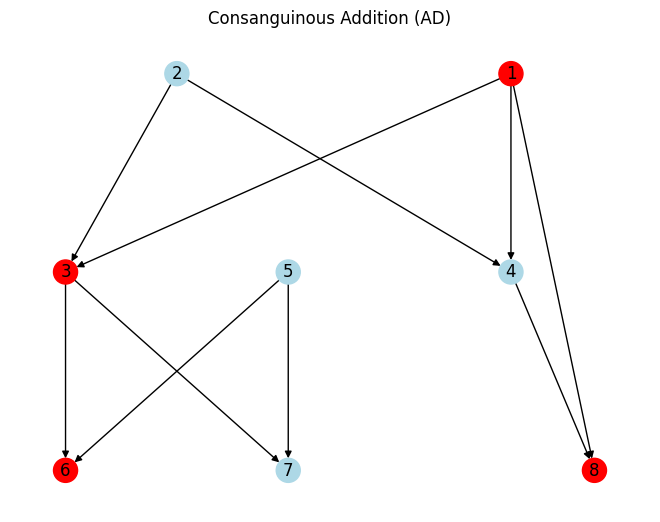

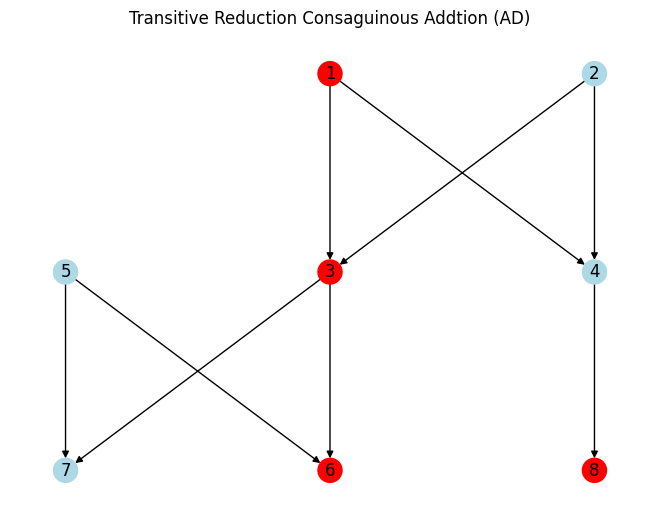

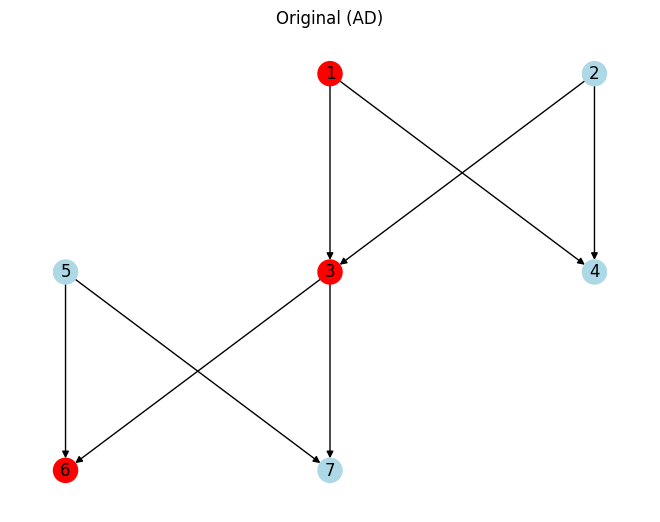

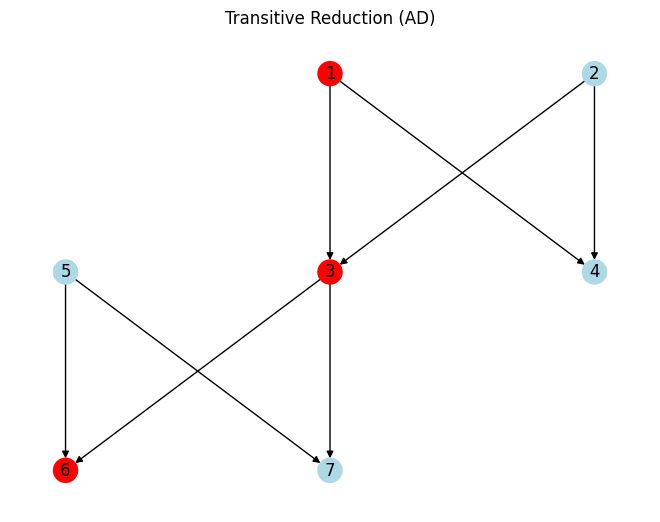

NameError: name 'dag_summary' is not defined

In [41]:
testG_AD = copy.deepcopy(G_ad)
testG_AD.add_node(8, family='FAM1', sex=1, phenotype=2)
testG_AD.add_edge(1, 8)
testG_AD.add_edge(4, 8)

test_trG_AD = nx.transitive_reduction(testG_AD)
test_trG_AD.add_nodes_from(testG_AD.nodes(data=True))
test_trG_AD.add_edges_from((u, v, testG_AD.edges[u,v]) for u, v in test_trG_AD.edges)

plot_pedigree_tree(testG_AD, title="Consanguinous Addition (AD)")
plot_pedigree_tree(test_trG_AD, title="Transitive Reduction Consaguinous Addtion (AD)")


trG_AD = nx.transitive_reduction(G_ad)
trG_AD.add_nodes_from(G_ad.nodes(data=True))
trG_AD.add_edges_from((u, v, G_ad.edges[u,v]) for u, v in trG_AD.edges)

plot_pedigree_tree(G_ad, title="Original (AD)")
plot_pedigree_tree(trG_AD, title="Transitive Reduction (AD)")

pprint(dag_summary(G_ad))